In [6]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import scipy as sp

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from typing import NamedTuple, Callable


import sys
import os
sys.path.append('../')
sys.path.append('../power_law_rf')
import optimizers
from power_law_rf.power_law_rf import PowerLawRF
from power_law_rf.ode import ode_resolvent_log_implicit
from power_law_rf.ode import DanaHparams
from power_law_rf.ode import ODEInputs
from power_law_rf.least_squares import lsq_streaming_optax_simple
import power_law_rf.deterministic_equivalent as theory

key = random.PRNGKey(0)

In [2]:
ALPHA = 1.0
BETALIST = [0.3, 0.7, 1.0,1.3]
V = 2000
D = 500
SGDBATCH=1
STEPS = 10**5

In [3]:
# Part 1: Generate data for each beta value
results_by_beta = []
for beta in BETALIST:
    key, newkey = random.split(key)
    # Create problem instance for this beta
    problem = PowerLawRF.initialize_random(ALPHA, beta, V, D, key=newkey)
    
    # # Run DANA decay
    # key, newkey = random.split(key)
    # danadecaytimes, danadecaylosses = lsq_streaming_optax_simple(
    #     newkey,
    #     problem.get_data,
    #     SGDBATCH,
    #     STEPS,
    #     danadecayopt,
    #     jnp.zeros((problem.d,1)),
    #     problem.get_population_risk
    #     )
    
    # Run SGD with fixed learning rate
    key, newkey = random.split(key)
    optimizer = optax.adam(learning_rate=0.001)
    adamtimes, adamlosses = lsq_streaming_optax_simple(
        newkey,
        problem.get_data,
        SGDBATCH,
        STEPS,
        optimizer,
        jnp.zeros((problem.d,1)),
        problem.get_population_risk
    )
    
    # Run Adam with cosine decay for different step sizes
    adam_cos_decay_results = []
    step_lengths = []
    current_steps = 1000
    while current_steps <= STEPS:
        step_lengths.append(current_steps)
        current_steps *= 4

    for steps in step_lengths:
        cos_decay = optax.cosine_decay_schedule(init_value=0.01, decay_steps=steps)
        adam_cos_decay = optax.adam(learning_rate=cos_decay)
        key, newkey = random.split(key)
        times, losses = lsq_streaming_optax_simple(
            newkey,
            problem.get_data,
            SGDBATCH,
            STEPS,
            adam_cos_decay,
            jnp.zeros((problem.d,1)),
            problem.get_population_risk
        )
        adam_cos_decay_results.append((times, losses))
    
    results_by_beta.append({
        'beta': beta,
        'adam': (adamtimes, adamlosses),
        'adam_cos': adam_cos_decay_results
    })



100%|██████████| 106/106 [00:15<00:00,  6.65it/s]


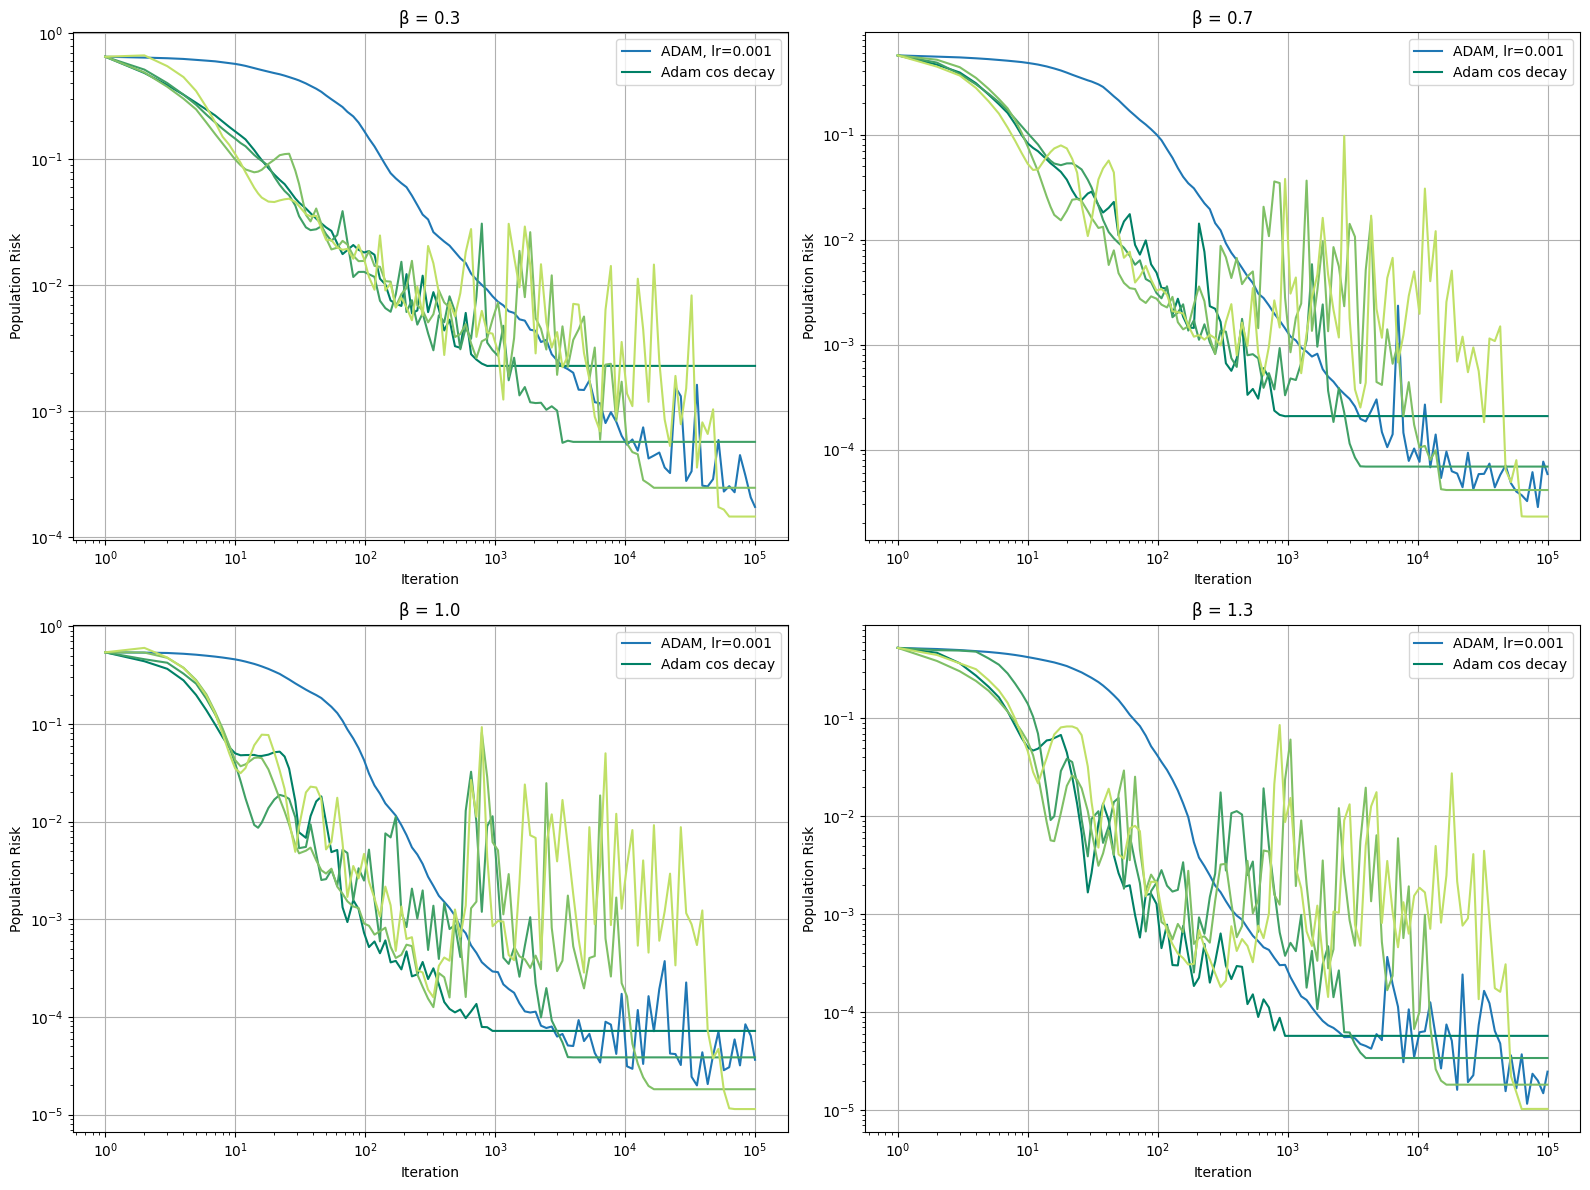

In [4]:
# Part 2: Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, result in enumerate(results_by_beta):
    beta = result['beta']
    adamtimes, adamlosses = result['adam']
    adam_cos_decay_results = result['adam_cos']
    
    # Plot on the corresponding subplot
    axes[idx].loglog(adamtimes+1, adamlosses, label='ADAM, lr=0.001')
    
    colors = cm.summer(jnp.linspace(0, 0.75, len(adam_cos_decay_results)))
    for (times, losses), color in zip(adam_cos_decay_results, colors):
        if jnp.array_equal(color, colors[0]):
            axes[idx].loglog(times+1, losses, color=color, label='Adam cos decay')
        else:
            axes[idx].loglog(times+1, losses, color=color)
    
    axes[idx].set_xlabel('Iteration')
    axes[idx].set_ylabel('Population Risk')
    axes[idx].set_title(f'β = {beta}')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()


In [82]:
class ADAMparams(NamedTuple):
    beta1: Callable[[float], float]  # momentum function
    lr: Callable[[float], float]  # learning rate function

def ode_adam_log_implicit(
    inputs: ODEInputs,
    opt_hparams: ADAMparams,
    batch: int,
    D: int,
    t_max: float,
    dt: float,
    approximate = False,
):
    """Generate the theoretical solution to ADAM, which we model with normalized SGD,
    replacing the normalization with twice the risk.

    Parameters
    ----------
    inputs : ODEInputs
        eigs_K : array d
            eigenvalues of covariance matrix (W^TDW)
        rho_init : array d
            initial rho_j's (rho_j^2)
        chi_init : array (d)
            initialization of chi's
        sigma_init : array (d)
            initialization of sigma's (xi^2_j)
        risk_infinity : scalar
            represents the risk value at time infinity

    opt_hparams : optimizer hyperparameters for ADAM
        b1 : function(time)
            momentum function
        lr : function(time)
            learning rate schedule

    batch : int
        batch size
    D : int
        number of eigenvalues (i.e. shape of eigs_K)
    t_max : float
        The number of epochs
    dt : float
        time step used in Euler

    Returns
    -------
    t_grid: numpy.array(float)
        the time steps used, which will discretize (0,t_max) into n_grid points
    risks: numpy.array(float)
        the values of the risk
    """
    #g1, g2, g3, delta = opt_hparams.g1, opt_hparams.g2, opt_hparams.g3, opt_hparams.delta
    delta = lambda f : 1-opt_hparams.beta1(f)
    g1 = lambda f : 1-opt_hparams.beta1(f)
    g2 = lambda f : 0
    g3 = opt_hparams.lr 

    eigs_K = inputs.eigs_K
    rho_init, chi_init, sigma_init = inputs.rho_init, inputs.chi_init, inputs.sigma_init
    risk_infinity = inputs.risk_infinity
    times = jnp.arange(0, jnp.log(t_max), step=dt, dtype=jnp.float32)
    risk_init = inputs.risk_infinity + jnp.sum(inputs.eigs_K * inputs.rho_init)
    

    def inverse_3x3(omega):
        # Extract matrix elements
        a11, a12, a13 = omega[0][0], omega[0][1], omega[0][2]
        a21, a22, a23 = omega[1][0], omega[1][1], omega[1][2]
        a31, a32, a33 = omega[2][0], omega[2][1], omega[2][2]

        # Calculate determinant
        det = (a11*a22*a33 + a12*a23*a31 + a13*a21*a32
               - a13*a22*a31 - a11*a23*a32 - a12*a21*a33)

        #if abs(det) < 1e-10:
        #    raise ValueError("Matrix is singular or nearly singular")

        # Calculate each element of inverse matrix
        inv = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

        inv[0][0] = (a22*a33 - a23*a32) / det
        inv[0][1] = (a13*a32 - a12*a33) / det
        inv[0][2] = (a12*a23 - a13*a22) / det

        inv[1][0] = (a23*a31 - a21*a33) / det
        inv[1][1] = (a11*a33 - a13*a31) / det
        inv[1][2] = (a13*a21 - a11*a23) / det

        inv[2][0] = (a21*a32 - a22*a31) / det
        inv[2][1] = (a12*a31 - a11*a32) / det
        inv[2][2] = (a11*a22 - a12*a21) / det

        return jnp.array(inv)

    def omega_full(time_plus,grad_norm):
        omega_11 = -2.0 * batch * g2(time_plus) * eigs_K + batch * (batch + 1.0) * g2(time_plus)**2 * eigs_K**2
        omega_12 = (g3(time_plus)**2/grad_norm**2) * jnp.ones_like(eigs_K)
        omega_13 = 2.0 * (g3(time_plus)/grad_norm) * (-1.0 + g2(time_plus) * batch * eigs_K)
        omega_1 = jnp.array([omega_11, omega_12, omega_13])

        omega_21 = batch * (batch + 1.0) * g1(time_plus)**2 * eigs_K**2
        omega_22 = (-2.0 * delta(time_plus) + delta(time_plus)**2) * jnp.ones_like(eigs_K)
        omega_23 = 2.0 * g1(time_plus) * eigs_K * batch * (1.0 - delta(time_plus))
        omega_2 = jnp.array([omega_21, omega_22, omega_23])

        omega_31 = g1(time_plus) * batch * eigs_K
        omega_32 = -(g3(time_plus)/grad_norm) * jnp.ones_like(eigs_K)
        omega_33 = -delta(time_plus) - g2(time_plus) * batch * eigs_K
        omega_3 = jnp.array([omega_31, omega_32, omega_33])

        omega = jnp.array([omega_1, omega_2, omega_3])  # 3 x 3 x d
        return omega

    def omega_approximate(time_plus,grad_norm):
        omega11 = -2.0 * batch * g2(time_plus) * eigs_K
        omega12 = 0.0 * jnp.ones_like(eigs_K)
        omega13 = 2.0 * (g3(time_plus)/grad_norm) * -1.0 * jnp.ones_like(eigs_K)
        omega1 = jnp.array([omega11, omega12, omega13])

        omega21 = 0.0 * jnp.ones_like(eigs_K)
        omega22 = (-2.0 * delta(time_plus)) * jnp.ones_like(eigs_K)
        omega23 = 2.0 * g1(time_plus) * eigs_K * batch
        omega2 = jnp.array([omega21, omega22, omega23])

        omega31 = g1(time_plus) * batch * eigs_K
        omega32 = -(g3(time_plus)/grad_norm) * jnp.ones_like(eigs_K)
        omega33 = -delta(time_plus) - g2(time_plus) * batch * eigs_K
        omega3 = jnp.array([omega31, omega32, omega33])

        omega = jnp.array([omega1, omega2, omega3]) #3 x 3 x d
        return omega


    def ode_update(carry, time):
        v, risk = carry
        time_plus = jnp.exp(time + dt)
        omega = omega_approximate(time_plus,jnp.sqrt(risk)) if approximate else omega_full(time_plus,jnp.sqrt(risk))
        identity = jnp.tensordot(jnp.eye(3), jnp.ones(D), 0)

        A = inverse_3x3(identity - (dt * time_plus) * omega)  # 3 x 3 x d

        Gamma = jnp.array([batch * g2(time_plus)**2,
                           batch * g1(time_plus)**2, 0.0])
        z = jnp.einsum('i, j -> ij', jnp.array([1.0, 0.0, 0.0]), eigs_K)
        G_lambda = jnp.einsum('i,j->ij', Gamma, inputs.eigs_K)  # 3 x d

        x_temp = v + dt * time_plus * inputs.risk_infinity * G_lambda
        x = jnp.einsum('ijk, jk -> ik', A, x_temp)

        y = jnp.einsum('ijk, jk -> ik', A, G_lambda)

        v_new = x + (dt * time_plus * y * jnp.sum(x * z) /
                    (1.0 - dt * time_plus * jnp.sum(y * z)))

        risk_new = risk_infinity + jnp.sum(eigs_K * v_new[0])
        return (v_new, risk_new), risk

    init_carry = (jnp.array([rho_init, sigma_init, chi_init]), risk_init)
    _, risks = jax.lax.scan(ode_update, init_carry, times)
    return jnp.exp(times), risks / 2

In [83]:
# Initialize lists to store ODE results for each beta
ode_results_by_beta = []

for beta in BETALIST:
    # Initialize the rhos for this beta
    initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
    initY = jnp.zeros(problem.d, dtype=jnp.float32)
    
    # Get theory rhos for this beta
    fake_eigs, rho_init = theory.theory_rhos(problem.alpha, beta, problem.d)
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)
    
    riskInftyTheory = theory.theory_limit_loss(problem.alpha, beta, problem.v, problem.d)
    
    Dt = 10**(-3)
    
#    lr = optax.schedules.constant_schedule(0.001)


    # Run Adam with cosine decay for different step sizes
    adam_cos_decay_results = []
    step_lengths = []
    current_steps = 1000
    while current_steps <= STEPS:
        step_lengths.append(current_steps)
        current_steps *= 4

    for steps in step_lengths:
        cos_decay = optax.cosine_decay_schedule(init_value=0.01, decay_steps=steps)
        b1 = optax.schedules.constant_schedule(0.95)
        # Run ODE for this beta
        odeTimes, odeRisks = ode_adam_log_implicit(
            ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
            ADAMparams(b1,cos_decay),
            SGDBATCH, problem.d, STEPS, Dt)
        adam_cos_decay_results.append((odeTimes, odeRisks))


        
    ode_results_by_beta.append({
        'beta': beta,
        'adam_cos_decay': adam_cos_decay_results,
    })

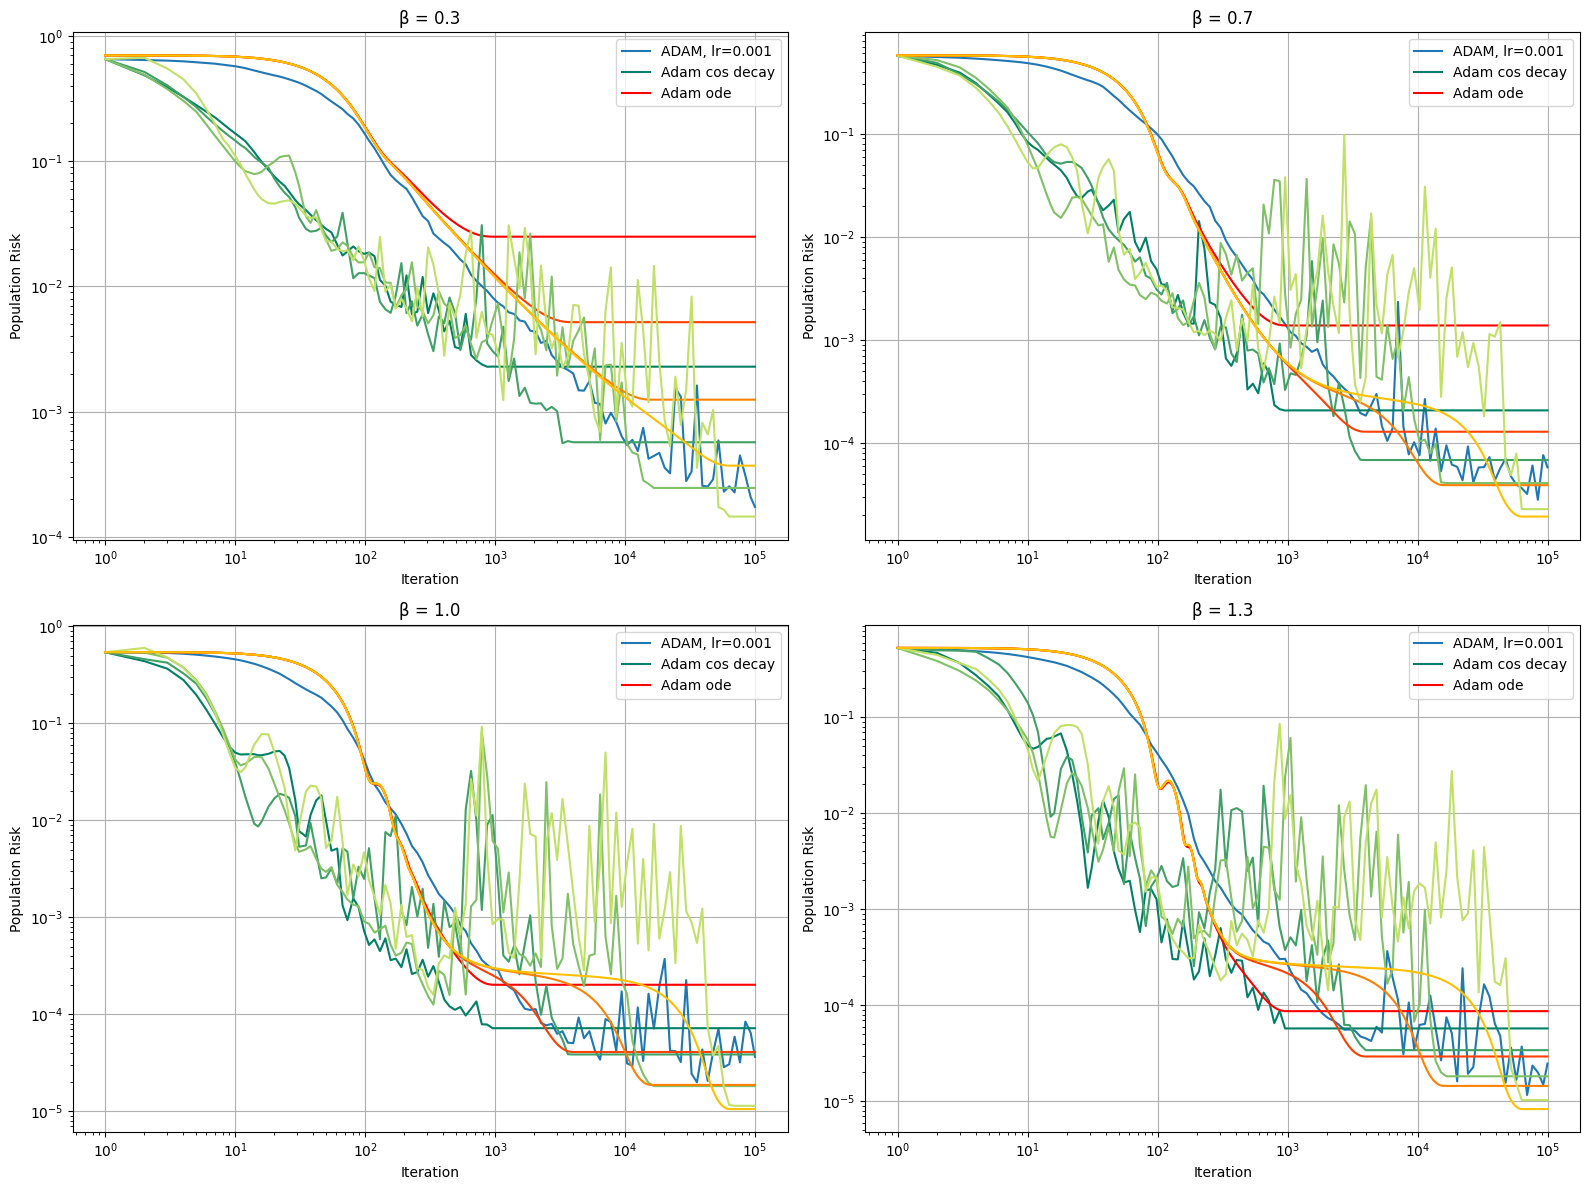

In [ ]:
# Part 2: Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (result, ode_result) in enumerate(zip(results_by_beta, ode_results_by_beta)):
    beta = result['beta']
    adamtimes, adamlosses = result['adam']
    adam_cos_decay_results = result['adam_cos']
    adam_ode_results = ode_result['adam_cos_decay']

    
    # Plot on the corresponding subplot
    axes[idx].loglog(adamtimes+1, adamlosses, label='ADAM, lr=0.001')
    #axes[idx].loglog(ode_result['times']/2, ode_result['risks'], label='ODE')

    
    
    adam_colors = cm.summer(jnp.linspace(0, 0.75, len(adam_cos_decay_results)))
    ode_colors = cm.autumn(jnp.linspace(0, 0.75, len(adam_ode_results)))
    for (times, losses),(ode_times, ode_losses), color, ode_color in zip(adam_cos_decay_results,adam_ode_results, adam_colors,ode_colors):
        if jnp.array_equal(color, colors[0]):
            axes[idx].loglog(times+1, losses, color=color, label='Adam cos decay')
            axes[idx].loglog(ode_times, ode_losses, color=ode_color, label='Adam ode')
        else:
            axes[idx].loglog(times+1, losses, color=color)
            axes[idx].loglog(ode_times, ode_losses, color=ode_color)

    
    axes[idx].set_xlabel('Iteration')
    axes[idx].set_ylabel('Population Risk')
    axes[idx].set_title(f'β = {beta}')
    axes[idx].grid(True)
    axes[idx].legend()
    

plt.tight_layout()
#plt.savefig('adam_cos_decay_beta_panel.pdf')

Scaled-up version

In [88]:
fake_eigs.shape

(10000,)

In [114]:
# Initialize lists to store ODE results for each beta
large_ode_results_by_beta = []
lr_scales = [0.1/(2**i) for i in range(15)]
step_lengths = []
current_steps = 1000
while current_steps <= STEPS:
    step_lengths.append(current_steps)
    current_steps *= 4

large_d=100000
large_v=500000

for beta in BETALIST:
    for lr_scale in lr_scales:
        # Initialize the rhos for this beta
        initTheta = jnp.zeros(large_d, dtype=jnp.float32)
        initY = jnp.zeros(large_d, dtype=jnp.float32)

        # Get theory rhos for this beta
        fake_eigs, rho_init = theory.theory_rhos(ALPHA, beta, large_d)
        sigma_init = jnp.zeros_like(rho_init)
        chi_init = jnp.zeros_like(rho_init)

        riskInftyTheory = theory.theory_limit_loss(ALPHA, beta, large_v, large_d)

        Dt = 10**(-3)

        # Run Adam with cosine decay for different step sizes
        adam_cos_decay_results = []

        for steps in step_lengths:
            cos_decay = optax.cosine_decay_schedule(init_value=lr_scale, decay_steps=steps)
            b1 = optax.schedules.constant_schedule(0.90)
            # Run ODE for this beta
            odeTimes, odeRisks = ode_adam_log_implicit(
                ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
                ADAMparams(b1, cos_decay),
                SGDBATCH, large_d, STEPS, Dt)
            adam_cos_decay_results.append((odeTimes, odeRisks))

        large_ode_results_by_beta.append({
            'beta': beta,
            'lr_scale': lr_scale,
            'adam_cos_decay': adam_cos_decay_results,
        })


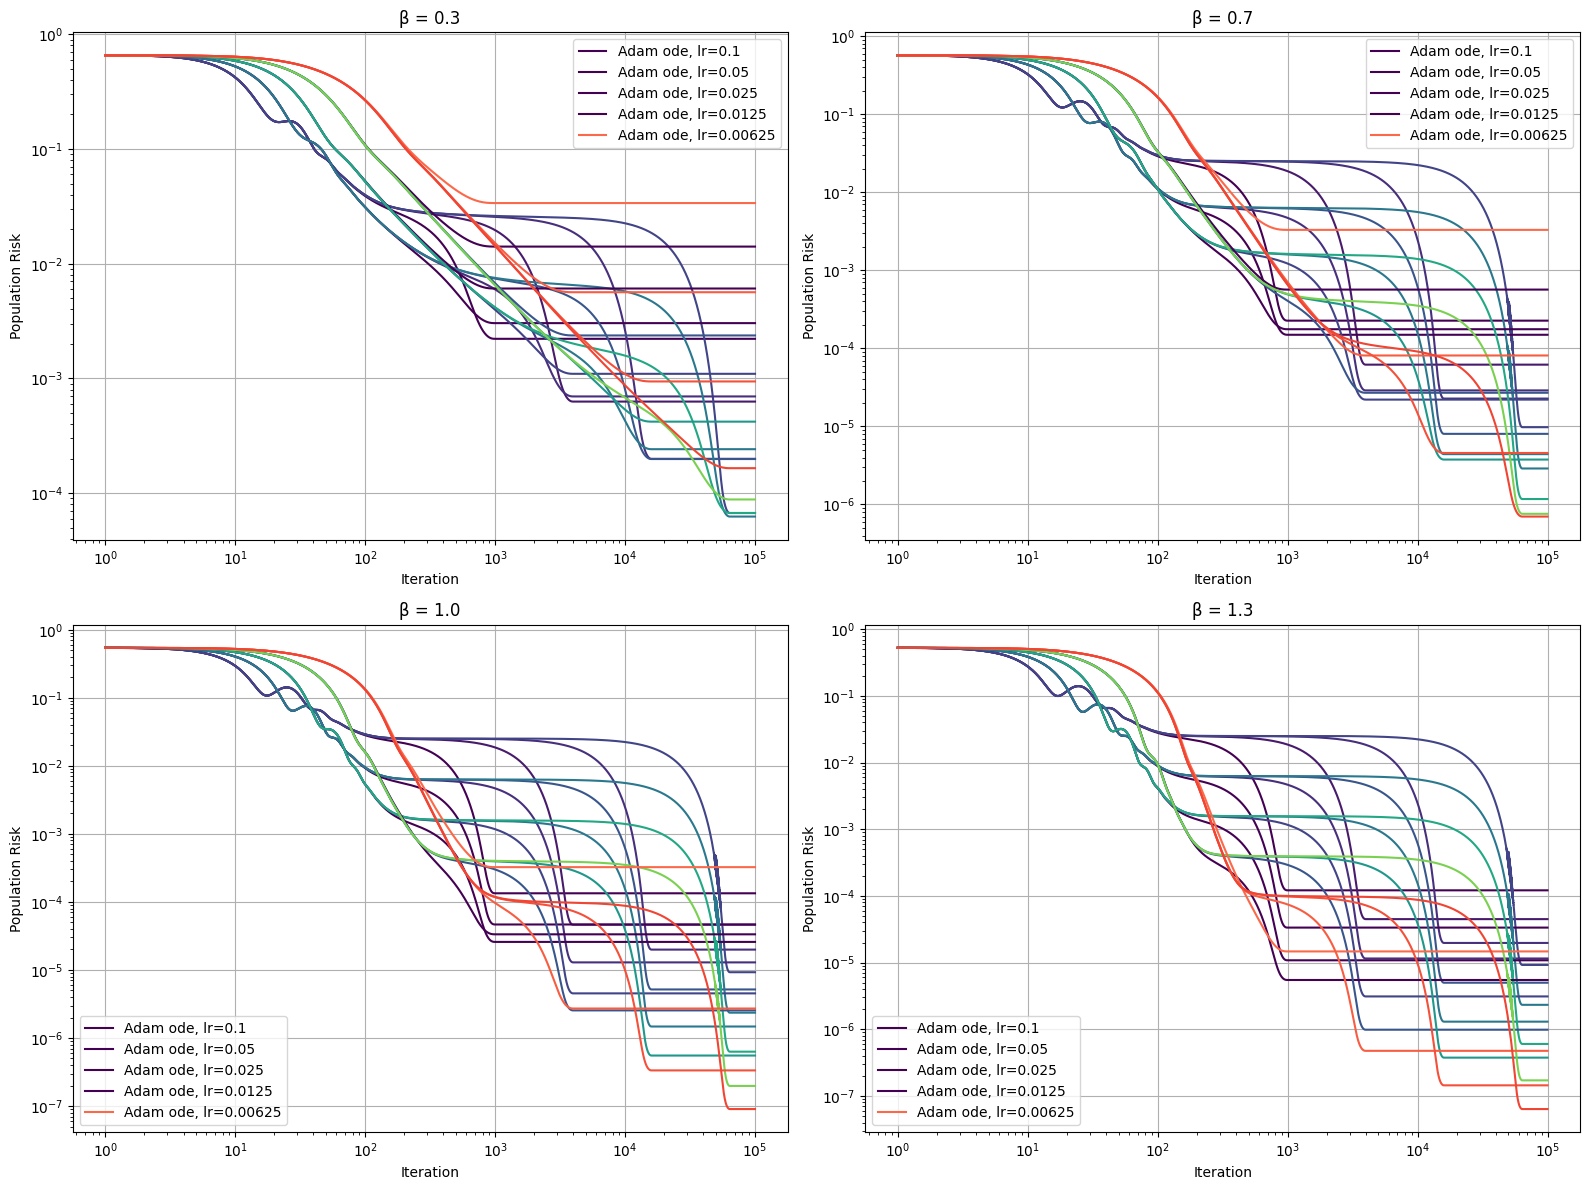

In [ ]:
# Part 2: Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

beta_to_idx = {beta: i for i, beta in enumerate(BETALIST)}

for ode_result in large_ode_results_by_beta:
    beta = ode_result['beta']
    lr_scale = ode_result['lr_scale']
    adam_ode_results = ode_result['adam_cos_decay']
    
    ax = axes[beta_to_idx[beta]]
    
    # Plot on the corresponding subplot
    shift = lr_scales.index(lr_scale) / len(lr_scales)
    if shift == max(lr_scales.index(scale) / len(lr_scales) for scale in lr_scales):
        ode_colors = cm.Reds(jnp.linspace(0.5, 0.6, len(adam_ode_results)))
    else:
        ode_colors = cm.viridis(jnp.linspace(0, 0.2 + shift, len(adam_ode_results)))
    
    for (ode_times, ode_losses), ode_color in zip(adam_ode_results, ode_colors):
        if jnp.array_equal(ode_color, ode_colors[0]):
            ax.loglog(ode_times, ode_losses, color=ode_color, label=f'Adam ode, lr={lr_scale:.2e}')
        else:
            ax.loglog(ode_times, ode_losses, color=ode_color)
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'β = {beta}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()

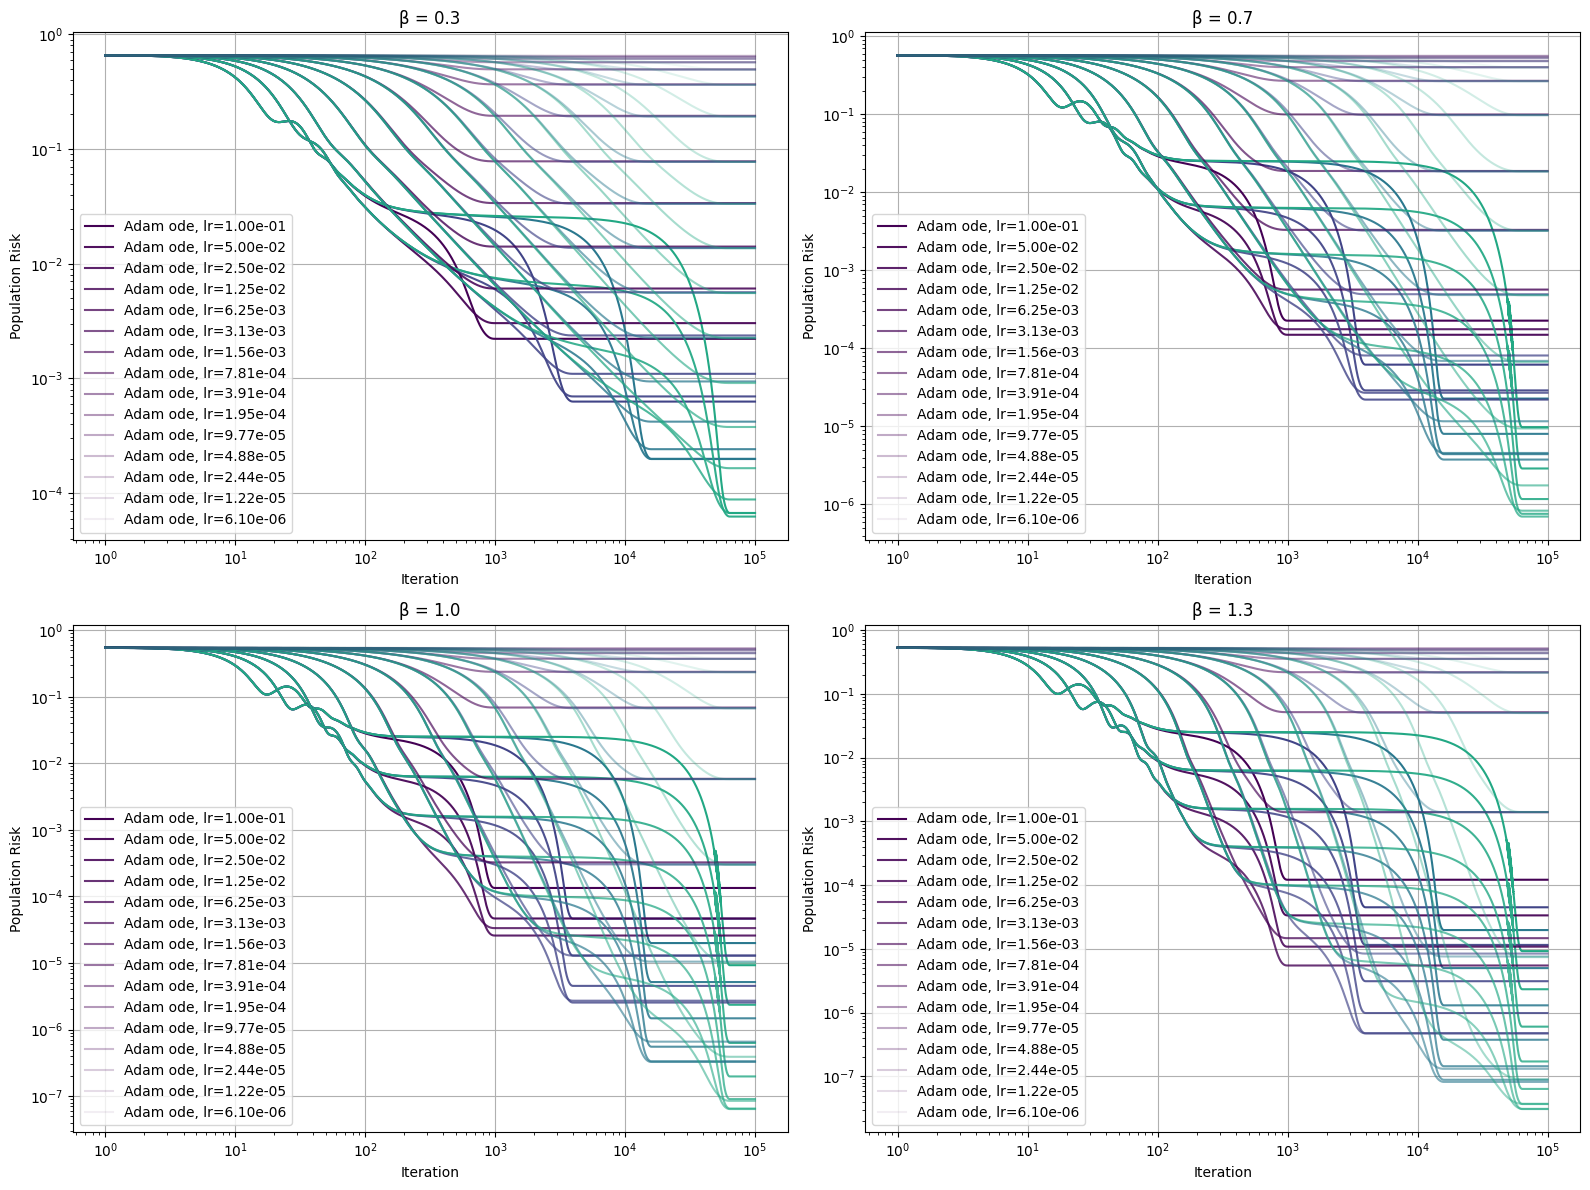

In [116]:
# Part 2: Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

beta_to_idx = {beta: i for i, beta in enumerate(BETALIST)}

for ode_result in large_ode_results_by_beta:
    beta = ode_result['beta']
    lr_scale = ode_result['lr_scale']
    adam_ode_results = ode_result['adam_cos_decay']
    
    ax = axes[beta_to_idx[beta]]
    
    # Plot on the corresponding subplot
    alpha = 1 - (lr_scales.index(lr_scale) / len(lr_scales))
    
    for idx, (ode_times, ode_losses) in enumerate(adam_ode_results):
        color = cm.viridis(0.8 * idx / len(adam_ode_results))
        ax.loglog(ode_times, ode_losses, color=color, alpha=alpha, label=f'Adam ode, lr={lr_scale:.2e}' if idx == 0 else "")
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'β = {beta}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig('adam_cos_decay_scaling_law.pdf')
